# Dataset sources

https://data.mendeley.com/datasets/f45bkkt8pr/1
https://www.kaggle.com/datasets/subhajournal/phishingemails

# Hugging Face API


In [12]:
from huggingface_hub import notebook_login
notebook_login()

# Imports

In [29]:
import kagglehub
import re
import pandas as pd
import os
# from google.colab import drive
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
!pip install wordcloud
!pip install tensorboard # for TPUs
from wordcloud import WordCloud
from collections import Counter
import torch
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    EarlyStoppingCallback
)
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report
from sklearn.preprocessing import LabelEncoder
from datasets import Dataset
from sklearn.model_selection import StratifiedKFold


In [14]:
path = kagglehub.dataset_download("subhajournal/phishingemails")
os.listdir(path)
df_email = pd.read_csv(path + "/" + os.listdir(path)[0])

#drive.mount("/content/drive/")
df_sms = pd.read_csv("./gpu/content/data/dataset_sms.csv")



Using Colab cache for faster access to the 'phishingemails' dataset.


# Data exploration

##### Visualization Functions

In [15]:
def clean_special_char(text):
    if pd.isna(text):
        return text

    text = text.lower()

    try:
        text = text.encode('latin1').decode('utf-8', errors='ignore')
    except:
        pass

    text = text.replace('\\n', ' ').replace('\n', ' ').replace('\r', ' ')
    text = text.encode('ascii', errors='ignore').decode('ascii')
    text = re.sub(r'\s+', ' ', text).strip()
    return text

class TextDataVisualizer:

    def __init__(self, df, text_column, label_column):
        self.df = df.copy()
        self.text_column = text_column
        self.label_column = label_column

        self.df['text_length'] = self.df[text_column].astype(str).str.len()
        self.df['word_count'] = self.df[text_column].astype(str).str.split().str.len()

        sns.set_style("whitegrid")

    def plot_class_distribution(self, figsize=(15, 5)):
        fig, axes = plt.subplots(1, 2, figsize=figsize)

        counts = self.df[self.label_column].value_counts()
        colors = ['green' if label == 'safe' else 'red' for label in counts.index]
        counts.plot(kind='bar', ax=axes[0], color=colors)
        axes[0].set_title(f'{self.label_column} Distribution', fontsize=14, fontweight='bold')
        axes[0].set_xlabel('Type')
        axes[0].set_ylabel('Count')
        axes[0].tick_params(axis='x', rotation=45)

        for i, v in enumerate(counts.values):
            axes[0].text(i, v + 0.5, str(v), ha='center', va='bottom', fontweight='bold')

        axes[1].pie(counts, labels=counts.index, autopct='%1.1f%%',
                   colors=colors, startangle=90)
        axes[1].set_title('Safe vs Phishing Ratio', fontsize=14, fontweight='bold')

        plt.tight_layout()
        plt.show()

        print("="*60)
        print("CLASS DISTRIBUTION")
        print("="*60)
        print(counts)
        print(f"\nTotal: {len(self.df)} samples")

    def plot_text_length_analysis(self, figsize=(15, 10)):
        fig, axes = plt.subplots(2, 2, figsize=figsize)

        # FIX: Use proper boxplot with correct data grouping
        data_to_plot_length = [self.df[self.df[self.label_column] == label]['text_length'].values
                               for label in sorted(self.df[self.label_column].unique())]

        bp1 = axes[0, 0].boxplot(data_to_plot_length,
                                  labels=sorted(self.df[self.label_column].unique()),
                                  patch_artist=True)
        for patch, label in zip(bp1['boxes'], sorted(self.df[self.label_column].unique())):
            patch.set_facecolor('green' if label == 'safe' else 'red')
            patch.set_alpha(0.6)
        axes[0, 0].set_title('Text Length by Type', fontsize=12, fontweight='bold')
        axes[0, 0].set_xlabel('Type')
        axes[0, 0].set_ylabel('Characters')
        axes[0, 0].grid(True, alpha=0.3)

        # Word count boxplot
        data_to_plot_words = [self.df[self.df[self.label_column] == label]['word_count'].values
                             for label in sorted(self.df[self.label_column].unique())]

        bp2 = axes[0, 1].boxplot(data_to_plot_words,
                                  labels=sorted(self.df[self.label_column].unique()),
                                  patch_artist=True)
        for patch, label in zip(bp2['boxes'], sorted(self.df[self.label_column].unique())):
            patch.set_facecolor('green' if label == 'safe' else 'red')
            patch.set_alpha(0.6)
        axes[0, 1].set_title('Word Count by Type', fontsize=12, fontweight='bold')
        axes[0, 1].set_xlabel('Type')
        axes[0, 1].set_ylabel('Words')
        axes[0, 1].grid(True, alpha=0.3)

        # Histograms
        for label in self.df[self.label_column].unique():
            data = self.df[self.df[self.label_column] == label]['text_length']
            color = 'green' if label == 'safe' else 'red'
            axes[1, 0].hist(data, bins=50, alpha=0.6, label=label, color=color)
        axes[1, 0].set_xlabel('Length (chars)')
        axes[1, 0].set_ylabel('Frequency')
        axes[1, 0].set_title('Length Distribution', fontsize=12, fontweight='bold')
        axes[1, 0].legend()
        axes[1, 0].grid(True, alpha=0.3)

        for label in self.df[self.label_column].unique():
            data = self.df[self.df[self.label_column] == label]['word_count']
            color = 'green' if label == 'safe' else 'red'
            axes[1, 1].hist(data, bins=50, alpha=0.6, label=label, color=color)
        axes[1, 1].set_xlabel('Word Count')
        axes[1, 1].set_ylabel('Frequency')
        axes[1, 1].set_title('Word Count Distribution', fontsize=12, fontweight='bold')
        axes[1, 1].legend()
        axes[1, 1].grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

        print("="*60)
        print("LENGTH STATS BY TYPE")
        print("="*60)
        print(self.df.groupby(self.label_column)[['text_length', 'word_count']].describe())

    def plot_wordclouds(self, figsize=(16, 6)):
        fig, axes = plt.subplots(1, 2, figsize=figsize)

        labels = self.df[self.label_column].unique()
        colormaps = {'safe': 'Greens', 'phishing': 'Reds'}

        for idx, label in enumerate(sorted(labels)):
            text = ' '.join(self.df[self.df[self.label_column] == label][self.text_column].astype(str))

            colormap = colormaps.get(label, 'viridis')
            wordcloud = WordCloud(width=800, height=400,
                                 background_color='white',
                                 colormap=colormap,
                                 max_words=100).generate(text)

            axes[idx].imshow(wordcloud, interpolation='bilinear')
            axes[idx].axis('off')
            axes[idx].set_title(f'Top Words - {label.upper()}',
                               fontsize=16, fontweight='bold')

        plt.tight_layout()
        plt.show()

    def get_top_words(self, texts, n=20, min_length=2):
        # Basic stopwords (EN + FR)
        stop_words = {
            'the', 'a', 'an', 'and', 'or', 'but', 'in', 'on', 'at', 'to', 'for',
            'of', 'is', 'are', 'was', 'were', 'be', 'been', 'have', 'has', 'had',
            'le', 'la', 'les', 'un', 'une', 'des', 'et', 'ou', 'mais', 'dans',
            'sur', 'pour', 'avec', 'est', 'sont', 'été', 'avoir', 'être'
        }

        words = ' '.join(texts).lower().split()
        words = [w for w in words if w not in stop_words and len(w) > min_length]

        return Counter(words).most_common(n)

    def plot_top_words(self, n=20, figsize=(16, 6)):
        fig, axes = plt.subplots(1, 2, figsize=figsize)

        labels = sorted(self.df[self.label_column].unique())
        colors = {'safe': 'green', 'phishing': 'red'}

        for idx, label in enumerate(labels):
            texts = self.df[self.df[self.label_column] == label][self.text_column].astype(str)
            top_words = self.get_top_words(texts, n=n)

            if top_words:
                words, counts = zip(*top_words)

                y_pos = range(len(words))
                color = colors.get(label, 'blue')
                axes[idx].barh(y_pos, counts, color=color, alpha=0.7)
                axes[idx].set_yticks(y_pos)
                axes[idx].set_yticklabels(words)
                axes[idx].invert_yaxis()
                axes[idx].set_title(f'Top {n} Words - {label.upper()}',
                                   fontsize=14, fontweight='bold')
                axes[idx].set_xlabel('Frequency')
                axes[idx].grid(True, alpha=0.3, axis='x')

        plt.tight_layout()
        plt.show()

    def plot_all(self, top_n_words=20):
        print(f"\n{'='*60}")
        print(f"FULL ANALYSIS - Column: {self.text_column}")
        print(f"{'='*60}\n")

        self.plot_class_distribution()
        print("\n")
        self.plot_text_length_analysis()
        print("\n")
        self.plot_wordclouds()
        self.plot_top_words(n=top_n_words)

    def get_summary_stats(self):
        stats = {
            'total_samples': len(self.df),
            'class_dist': self.df[self.label_column].value_counts().to_dict(),
            'avg_len_by_class': self.df.groupby(self.label_column)['text_length'].mean().to_dict(),
            'avg_words_by_class': self.df.groupby(self.label_column)['word_count'].mean().to_dict(),
            'median_len_by_class': self.df.groupby(self.label_column)['text_length'].median().to_dict(),
            'median_words_by_class': self.df.groupby(self.label_column)['word_count'].median().to_dict()
        }
        return stats


def compare_datasets(viz1, viz2, name1="Dataset 1", name2="Dataset 2"):
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))

    # Class distribution comparison
    counts1 = viz1.df[viz1.label_column].value_counts()
    counts2 = viz2.df[viz2.label_column].value_counts()

    x = np.arange(len(counts1))
    width = 0.35

    axes[0, 0].bar(x - width/2, counts1.values, width, label=name1, alpha=0.8)
    axes[0, 0].bar(x + width/2, counts2.values, width, label=name2, alpha=0.8)
    axes[0, 0].set_xlabel('Class')
    axes[0, 0].set_ylabel('Count')
    axes[0, 0].set_title('Distribution Comparison')
    axes[0, 0].set_xticks(x)
    axes[0, 0].set_xticklabels(counts1.index)
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # Avg length comparison
    avg1 = viz1.df.groupby(viz1.label_column)['text_length'].mean()
    avg2 = viz2.df.groupby(viz2.label_column)['text_length'].mean()

    x = np.arange(len(avg1))
    axes[0, 1].bar(x - width/2, avg1.values, width, label=name1, alpha=0.8)
    axes[0, 1].bar(x + width/2, avg2.values, width, label=name2, alpha=0.8)
    axes[0, 1].set_xlabel('Class')
    axes[0, 1].set_ylabel('Avg Length (chars)')
    axes[0, 1].set_title('Avg Length Comparison')
    axes[0, 1].set_xticks(x)
    axes[0, 1].set_xticklabels(avg1.index)
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    # Avg word count comparison
    words1 = viz1.df.groupby(viz1.label_column)['word_count'].mean()
    words2 = viz2.df.groupby(viz2.label_column)['word_count'].mean()

    axes[1, 0].bar(x - width/2, words1.values, width, label=name1, alpha=0.8)
    axes[1, 0].bar(x + width/2, words2.values, width, label=name2, alpha=0.8)
    axes[1, 0].set_xlabel('Class')
    axes[1, 0].set_ylabel('Avg Word Count')
    axes[1, 0].set_title('Word Count Comparison')
    axes[1, 0].set_xticks(x)
    axes[1, 0].set_xticklabels(words1.index)
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)

    # Summary table
    axes[1, 1].axis('tight')
    axes[1, 1].axis('off')

    table_data = [
        ['Metric', name1, name2],
        ['Total samples', len(viz1.df), len(viz2.df)],
        ['Avg length', f"{viz1.df['text_length'].mean():.1f}",
         f"{viz2.df['text_length'].mean():.1f}"],
        ['Avg words', f"{viz1.df['word_count'].mean():.1f}",
         f"{viz2.df['word_count'].mean():.1f}"]
    ]

    table = axes[1, 1].table(cellText=table_data, cellLoc='center', loc='center',
                            colWidths=[0.4, 0.3, 0.3])
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 2)

    for i in range(3):
        table[(0, i)].set_facecolor('#40466e')
        table[(0, i)].set_text_props(weight='bold', color='white')

    plt.tight_layout()
    plt.show()


# Usage
# email_viz = TextDataVisualizer(df_email, 'Email Text', 'Email Type')
# email_viz.plot_all()
# stats = email_viz.get_summary_stats()

##### SMS Dataset

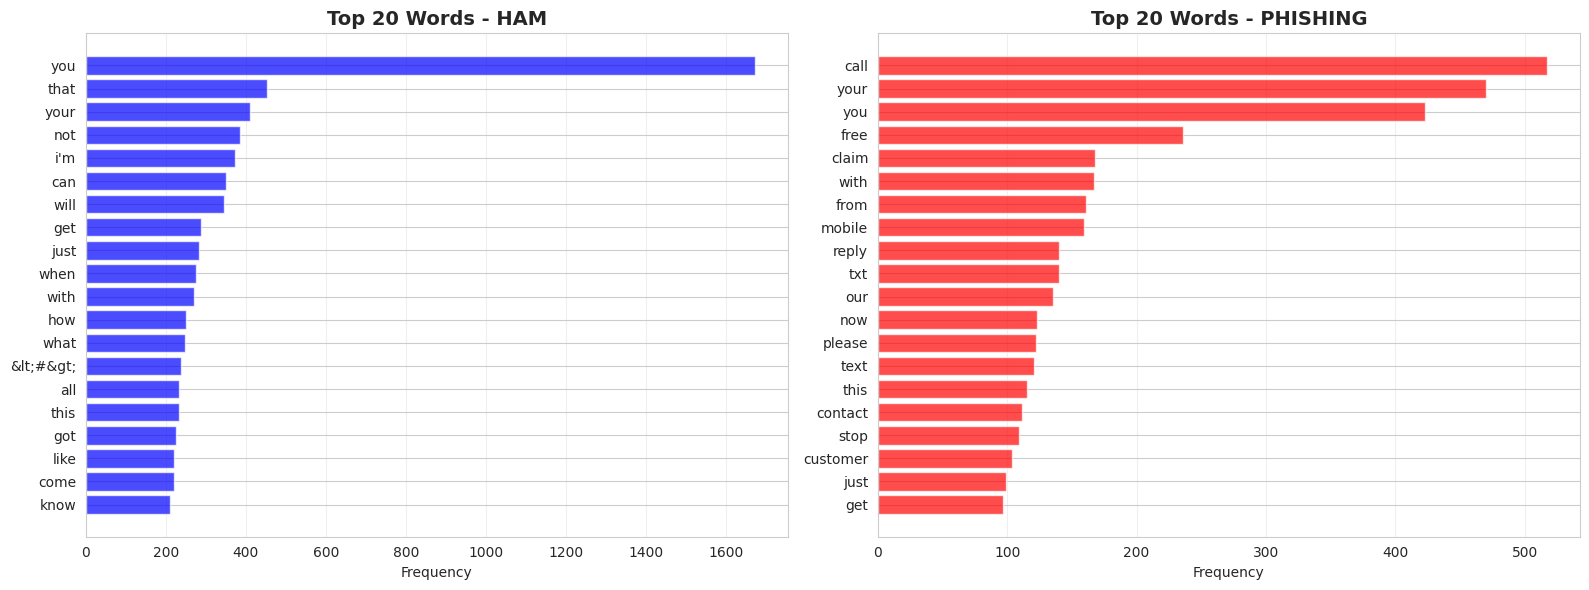

In [16]:
display(df_sms.head())
display(df_sms.describe())
display(df_sms.LABEL.value_counts())
# Labels format is not uniform. ex: "Spam" "spam"
display(df_sms[['URL', 'EMAIL', 'PHONE']].value_counts())
# Only 864 phone samples

# Normalize labels for df_sms to handle the IndexError in plot_wordclouds
df_sms['LABEL'] = df_sms['LABEL'].str.lower() # Convert all to lowercase first
df_sms['LABEL'] = df_sms['LABEL'].replace(['smishing', 'spam'], 'phishing') # Then replace specific categories

df_sms_vis = TextDataVisualizer(df_sms, 'TEXT', 'LABEL')
df_sms_vis.plot_all()

In [17]:
df_sms['LABEL'] = df_sms['LABEL'].str.lower()
df_sms['LABEL'] = df_sms['LABEL'].replace(['smishing', 'spam'], 'phishing')

df_sms = df_sms.rename(columns={'TEXT': 'text', 'LABEL': 'label'})
df_sms = df_sms.dropna()
df_sms['text'] = df_sms['text'].apply(clean_special_char)
df_sms['label'] = df_sms['label'].str.replace("ham", "safe")
df_sms = df_sms.drop(columns=['URL', 'EMAIL', 'PHONE'])
display(df_sms)

,label,text
0,safe,your opinion about me? 1. over 2. jada 3. kusr...
1,safe,what's up? do you want me to come online? if y...
2,safe,so u workin overtime nigpun?
3,safe,"also sir, i sent you an email about how to log..."
4,phishing,please stay at home. to encourage the notion o...
...,...,...
5966,safe,:( but your not here....
5967,safe,becoz its &lt;#&gt; jan whn al the post ofice ...
5968,safe,its a valentine game. . . send dis msg to all ...
5969,safe,we r outside already.


##### Email dataset

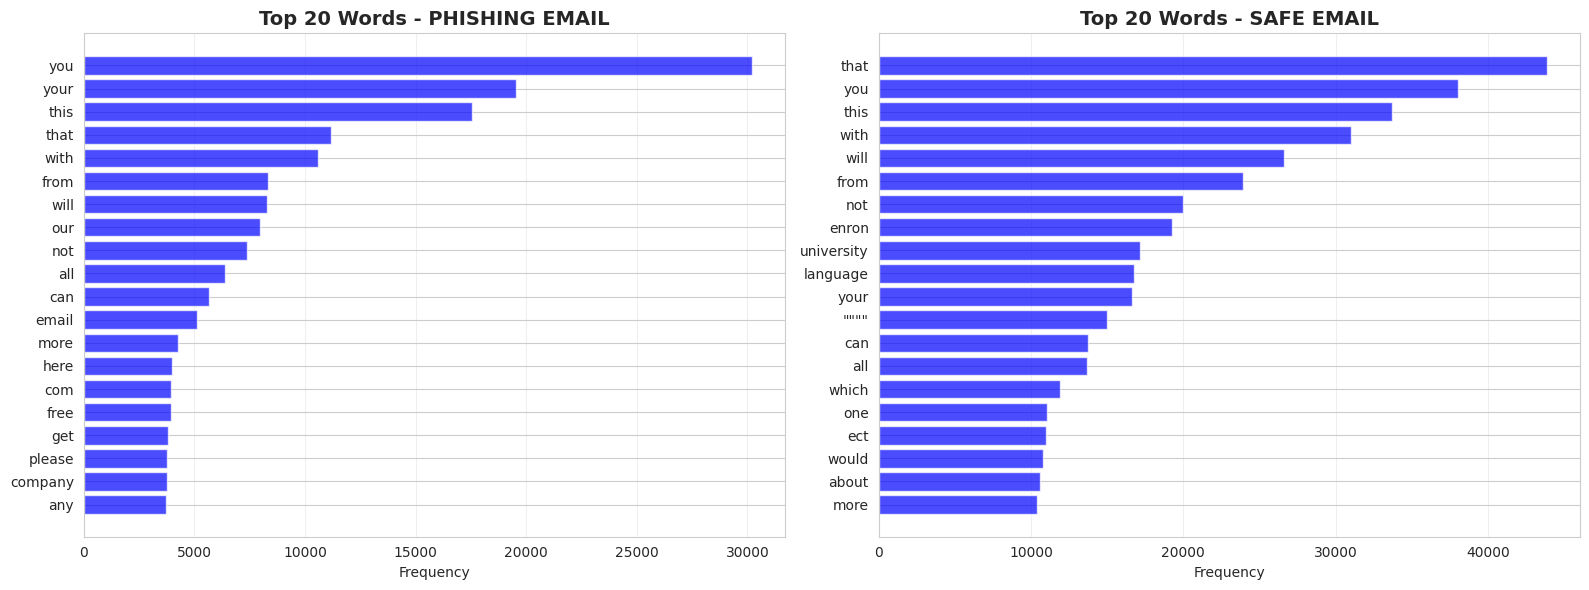

In [18]:
if "Unnamed: 0" in df_email.columns:
    df_email = df_email.drop(columns=["Unnamed: 0"])
display(df_email)
display(df_email.describe())
display(df_email.info())
df_email_vis = TextDataVisualizer(df_email, "Email Text", "Email Type")
df_email_vis.plot_all()


In [19]:
df_email['Email Text'] = df_email['Email Text'].replace('empty', np.nan) # empty is normalized to NaN
df_email['Email Type'] = df_email['Email Type'].str.replace('Email', '', case=False).str.strip().str.lower()
df_email = df_email.dropna()
df_email['Email Text'] = df_email['Email Text'].apply(clean_special_char)
df_email = df_email.rename(columns={'Email Text': 'text', 'Email Type': 'label'})
df_email

,text,label
0,"re : 6 . 1100 , disc : uniformitarianism , re ...",safe
1,the other side of * galicismos * * galicismo *...,safe
2,re : equistar deal tickets are you still avail...,safe
3,hello i am your hot lil horny toy. i am the on...,phishing
4,software at incredibly low prices ( 86 % lower...,phishing
...,...,...
18644,rick moen a crit:> > i'm confused. i thought i...,safe
18645,date a lonely housewife always wanted to date ...,phishing
18646,request submitted : access request for anita ....,safe
18647,"re : important - prc mtg hi dorn & john , as y...",safe


##### Results

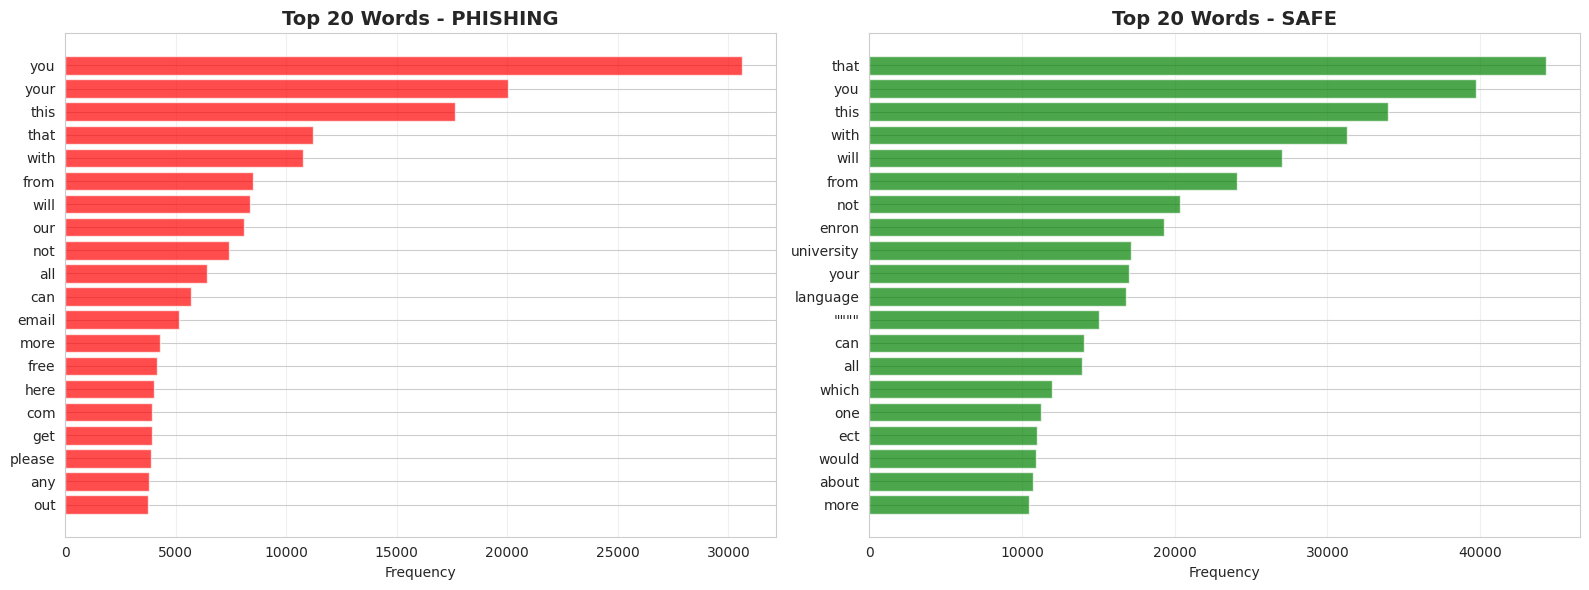

In [20]:
df = pd.concat([df_email, df_sms])
df_vis = TextDataVisualizer(df, 'text', 'label')
df_vis.plot_all()

# Fine-tuning

In [21]:
enc = LabelEncoder()
df['label'] = enc.fit_transform(df['label'])
X_train, X_test, y_train, y_test = train_test_split(
    df['text'],
    df['label'],
    test_size=0.2,
    stratify=df['label'],
    random_state=42
)

In [22]:

MODEL_NAME = "roberta-base"
MAX_LENGTH = 512
BATCH_SIZE = 32
EPOCHS = 3
LEARNING_RATE = 2e-5

print("Chargement du modèle RoBERTa...")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

num_labels = len(np.unique(y_train))
print(f"Nombre de classes : {num_labels}")

Nombre de classes : 2


In [23]:
def create_dataset(texts, labels):
    data_dict = {
        'text': texts.tolist() if hasattr(texts, 'tolist') else texts,
        'label': labels.tolist() if hasattr(labels, 'tolist') else labels
    }
    return Dataset.from_dict(data_dict)

def tokenize_function(examples):
    return tokenizer(
        examples['text'],
        padding='max_length',
        truncation=True,
        max_length=MAX_LENGTH
    )

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    precision, recall, f1, _ = precision_recall_fscore_support(
        labels,
        predictions,
        average=None,
        labels=[0, 1]
    )
    acc = accuracy_score(labels, predictions)

    return {
        'accuracy': acc,
        'f1_safe': f1[0],
        'f1_phishing': f1[1],
        'precision_safe': precision[0],
        'precision_phishing': precision[1],
        'recall_safe': recall[0],
        'recall_phishing': recall[1],
    }


In [24]:
# Training by cross validation instead

# train_dataset = create_dataset(X_train, y_train)
# test_dataset = create_dataset(X_test, y_test)
#
# print(f"Taille du dataset d'entraînement : {len(train_dataset)}")
# print(f"Taille du dataset de test : {len(test_dataset)}")
# print("Tokenization des données...")
# train_dataset = train_dataset.map(tokenize_function, batched=True)
# test_dataset = test_dataset.map(tokenize_function, batched=True)
#
# train_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])
# test_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])

In [41]:
%load_ext tensorboard
%tensorboard --logdir /content/data/runs

training_args = TrainingArguments(
    optim="adamw_torch",
    output_dir='/content/data',
    push_to_hub = False, # dont push intermediate kfold trainned model
    hub_model_id="roberta-finetuned-vishing", # Specify the model name for the hub
    num_train_epochs=EPOCHS,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    warmup_steps=500,
    weight_decay=0.01,
    learning_rate=LEARNING_RATE,
    logging_dir='./logs',
    logging_steps=100,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="eval_f1_phishing",
    greater_is_better=True,
    save_total_limit=2,
    fp16=torch.cuda.is_available(),
    report_to="tensorboard"
)

`logging_dir` is deprecated and will be removed in v5.2. Please set `TENSORBOARD_LOGGING_DIR` instead.


In [43]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
all_fold_metrics = []

X = df['text'].values
y = df['label'].values

for fold, (train_idx, val_idx) in enumerate(kf.split(X, y)):
    print(f"\n{'='*50}")
    print(f"FOLD {fold + 1}/5")
    print(f"{'='*50}")

    train_dataset = create_dataset(X[train_idx], y[train_idx])
    val_dataset   = create_dataset(X[val_idx],   y[val_idx])

    train_dataset = train_dataset.map(tokenize_function, batched=True)
    val_dataset   = val_dataset.map(tokenize_function, batched=True)
    train_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])
    val_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])

    model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=num_labels)

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
    )

    trainer.train()

fold_metrics = trainer.evaluate()
fold_metrics['fold'] = fold + 1
all_fold_metrics.append(fold_metrics)
print(f"Fold {fold+1} — F1 Phishing: {fold_metrics['eval_f1_phishing']:.4f} | F1 Safe: {fold_metrics['eval_f1_safe']:.4f} | Accuracy: {fold_metrics['eval_accuracy']:.4f}")

Fold 5 — F1 Phishing: 0.9914 | F1 Safe: 0.9829 | Accuracy: 0.9886


In [44]:
# BIAISED evaluation
# print("Évaluation sur le test set...")
# eval_results = trainer.evaluate()
#
# print("\n" + "="*50)
# print("RÉSULTATS DE LA VALIDATION")
# print("="*50)
# print(f"Accuracy: {eval_results['eval_accuracy']:.4f}")
# print(f"F1-Score: {eval_results['eval_f1']:.4f}")
# print(f"Precision: {eval_results['eval_precision']:.4f}")
# print(f"Recall: {eval_results['eval_recall']:.4f}")
# print(f"Loss: {eval_results['eval_loss']:.4f}")
#
# print("\nGénération des prédictions...")
# predictions = trainer.predict(test_dataset)
# pred_labels = np.argmax(predictions.predictions, axis=-1)
#
# print("\n" + "="*50)
# print("RAPPORT DE CLASSIFICATION DÉTAILLÉ")
# print("="*50)
# print(classification_report(y_test, pred_labels))

# Correct K Fold Evaluation
metrics_df = pd.DataFrame(all_fold_metrics)
print("\n" + "="*50)
print("RÉSULTATS CROSS-VALIDATION")
print("="*50)
print(metrics_df[[
    'fold',
    'eval_accuracy',
    'eval_f1_phishing',
    'eval_f1_safe',
    'eval_precision_phishing',
    'eval_precision_safe',
    'eval_recall_phishing',
    'eval_recall_safe'
]])
print(f"\nMoyenne F1 Phishing       : {metrics_df['eval_f1_phishing'].mean():.4f} ± {metrics_df['eval_f1_phishing'].std():.4f}")
print(f"Moyenne F1 Safe           : {metrics_df['eval_f1_safe'].mean():.4f} ± {metrics_df['eval_f1_safe'].std():.4f}")
print(f"Moyenne Precision Phishing: {metrics_df['eval_precision_phishing'].mean():.4f} ± {metrics_df['eval_precision_phishing'].std():.4f}")
print(f"Moyenne Precision Safe    : {metrics_df['eval_precision_safe'].mean():.4f} ± {metrics_df['eval_precision_safe'].std():.4f}")
print(f"Moyenne Recall Phishing   : {metrics_df['eval_recall_phishing'].mean():.4f} ± {metrics_df['eval_recall_phishing'].std():.4f}")
print(f"Moyenne Recall Safe       : {metrics_df['eval_recall_safe'].mean():.4f} ± {metrics_df['eval_recall_safe'].std():.4f}")
print(f"Moyenne Accuracy          : {metrics_df['eval_accuracy'].mean():.4f} ± {metrics_df['eval_accuracy'].std():.4f}")



RÉSULTATS CROSS-VALIDATION
   fold  eval_accuracy  eval_f1_phishing  eval_f1_safe  \
0     5       0.988575          0.991432      0.982861   

   eval_precision_phishing  eval_precision_safe  eval_recall_phishing  \
0                 0.986361             0.993073              0.996555   

   eval_recall_safe  
0          0.972856  

Moyenne F1 Phishing       : 0.9914 ± nan
Moyenne F1 Safe           : 0.9829 ± nan
Moyenne Precision Phishing: 0.9864 ± nan
Moyenne Precision Safe    : 0.9931 ± nan
Moyenne Recall Phishing   : 0.9966 ± nan
Moyenne Recall Safe       : 0.9729 ± nan
Moyenne Accuracy          : 0.9886 ± nan


In [ ]:
print("\n" + "="*50)
print("DÉBUT DE L'ENTRAÎNEMENT FINAL")
print("="*50 + "\n")

X = df['text'].values
y = df['label'].values

model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=num_labels)

full_train_dataset = create_dataset(X, y)
full_train_dataset = full_train_dataset.map(tokenize_function, batched=True)
full_train_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])

training_args_fin = TrainingArguments(
    push_to_hub = True,
    hub_model_id="roberta-finetuned-vishing", # Specify the model name for the hub
    num_train_epochs=EPOCHS,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    warmup_steps=500,
    weight_decay=0.01,
    learning_rate=LEARNING_RATE,
    logging_dir='./logs',
    logging_steps=100,
    eval_strategy="no",
    save_strategy="no",
    fp16=torch.cuda.is_available(),
    report_to="none"
)

trainer_fin = Trainer(
    model=model,
    args=training_args_fin,
    train_dataset= full_train_dataset,
)

trainer_fin.train()

print("\n" + "="*50)
print("ENTRAÎNEMENT FINAL TERMINÉ")
print("="*50 + "\n")

In [ ]:
id2label = {i: label for i, label in enumerate(enc.classes_)}
label2id = {label: i for i, label in enumerate(enc.classes_)}
model.config.id2label = id2label
model.config.label2id = label2id

trainer_fin.push_to_hub()
tokenizer.push_to_hub("roberta-finetuned-vishing")

# Test predictions

In [ ]:
def predict_text(text):
    # Ensure model is on the correct device for inference
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    inputs = tokenizer(
        text,
        return_tensors="pt",
        truncation=True,
        max_length=MAX_LENGTH,
        padding=True
    )

    # Move inputs to the same device as the model
    inputs = {key: val.to(device) for key, val in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)
        predictions = torch.argmax(outputs.logits, dim=-1)

    return predictions.item()

In [ ]:
text = "Well, if we want to beat the crowd, I was thinking of heading out around 8:00. I can swing by and pick you up if you want."
print(enc.classes_)
prediction = predict_text(text)
print(f"Prédiction: {prediction}")


# Save

In [ ]:
print("\nSauvegarde du modèle...")
model.save_pretrained('/content/drive/MyDrive/TP_IA/VISHIELD/roberta_finetuned_vishing')
tokenizer.save_pretrained('/content/drive/MyDrive/TP_IA/VISHIELD/roberta_finetuned_vishing')
print("Modèle sauvegardé dans './roberta_finetuned_vishing'")
